In [90]:
import numpy as np
import pickle as pkl
import json
import torch
import librosa
import os
import sys
import cv2
import shutil
from matplotlib import pyplot as plt
import csv
import shutil
from datetime import datetime
import soundfile as sf
import whisper_timestamped
from sklearn.mixture import GaussianMixture
# import utility functions
from torch.utils.data import Dataset
from scipy.interpolate import interp1d
import python_speech_features as psf
from transformers import BertTokenizer, BertModel

sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/Gaze_project')
sys.path.insert(0, '/scratch/ondemand27/evanpan/EvansToolBox/Utils/')
sys.path.insert(0, '/scratch/ondemand27/evanpan/Gaze_project/')
# sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/EvansToolBox")
from Signal_processing_utils import dx_dt
from Dataset_Util.dataloader import ShotDataSet_Selftape111, SegmentDataset_SelfTape111


In [91]:
def rotation_angles_frome_positions(arr):
    """
    converts an array of positions to an array of rotation angles (azimuth, elevation)
    centered at the origin, where:
        azimuth: +right,-left
        elevation: +up,-down
    here we assume that the input vectors are in world coordinates
    :param arr: array with shape (N, 3)
    :return: array with shape (N, 2)
    """
    # F: arr (N, 3) -> arr (N, 2) or arr (3, ) -> (2, )
    # in the output is in the convention of (azimuth, elevation)
    if len(arr.shape) == 2:
        mag = np.sqrt(np.sum(arr * arr, axis=1, keepdims=True))
        out = arr / mag
        out[:, 0] = np.arcsin(out[:, 0])
        out[:, 1] = np.arcsin(out[:, 1])
        return out[:, 0:2] * 180 / np.pi
    else:
        mag = np.sqrt(np.sum(arr * arr))
        out = arr / mag
        out[0] = np.arcsin(out[0])
        out[1] = np.arcsin(out[1])
        return out[0:2] * 180 / np.pi
def get_valid_shots(shots, fps, shot_length_mininmum=5):
    t0 = datetime.strptime("00:00:00.0", '%H:%M:%S.%f').timestamp()
    for shot in shots:
        start = shot[0]
        end = shot[1]
    # load the input shots range
    valid_shots_time, valid_shots_frames = [], []
    t0 = datetime.strptime("00:00:00.0", '%H:%M:%S.%f').timestamp()
    for i in range(len(shots)):
        start = datetime.strptime(shots[i][0], '%H:%M:%S.%f').timestamp()
        end = datetime.strptime(shots[i][1], '%H:%M:%S.%f').timestamp()
        if (end-start) >= shot_length_mininmum:
            start_t = start-t0
            end_t = end - t0
            valid_shots_time.append([start-t0, end-t0])
            valid_shots_frames.append([int(np.round(start_t*fps)), int(np.round(end_t*fps))])

    return valid_shots_time, valid_shots_frames
def load_head_and_gaze_angles(all_gaze_data, all_head_data):

    # head data
    head_angle_data = all_head_data["HEAD"]
    head_rotmat_per_frame = head_angle_data["ROTMAT"]
    head_bbox_per_frame = all_head_data["BBOX"] # we are not using but having it here is nice
    head_angle_per_frame = []
    neutral_position = np.array([0, 0, 100])
    for i in range(0, head_rotmat_per_frame.shape[0]):
        pos = head_rotmat_per_frame[i] @ neutral_position
        head_angle_per_frame.append(rotation_angles_frome_positions(pos[:]))
    head_angle_per_frame = np.array(head_angle_per_frame)
    # getting rotation angle in z direction
    neutral_position2 = np.array([0, 100, 0])
    head_angle_z_per_frame = []
    for i in range(0, head_rotmat_per_frame.shape[0]):
        pos = head_rotmat_per_frame[i] @ neutral_position2
        pos = np.array([pos[1], pos[2], pos[0]])
        head_angle_z_per_frame.append(rotation_angles_frome_positions(pos)[1])
    head_angle_xy_per_frame = np.array(head_angle_per_frame)
    head_angle_z_per_frame = np.expand_dims(np.array(head_angle_z_per_frame), axis=1)
    head_angle_per_frame = np.concatenate([head_angle_xy_per_frame, head_angle_z_per_frame], axis=1)

    # getting gaze data
    gaze_angle_data = all_gaze_data["RAW_GAZE"]
    gaze_angle_per_frame = gaze_angle_data["EULER"]
    gaze_rotmat_per_frame = gaze_angle_data["ROTMAT"]
    blinks = all_head_data["BLINKS"]
    gaze_vec = np.array([0, 0, 100])
    eye_angle_per_frame = []
    for i in range(0, gaze_rotmat_per_frame.shape[0]):
        eye_line = gaze_rotmat_per_frame[i] @ gaze_vec
        eye_line = eye_line / eye_line[2] * 100
        eye_angle_per_frame.append(eye_line)
    eye_angle_per_frame = np.array(eye_angle_per_frame)
    eye_angle_per_frame = rotation_angles_frome_positions(eye_angle_per_frame[:])
    return eye_angle_per_frame, head_angle_per_frame

# Input Block

In [92]:
input_folder = "/Volumes/EVAN_DISK/MASC/Ribhav_processed_dataset/"
output_folder = "/Volumes/EVAN_DISK/MASC/deep_learning_processed_dataset/"
input_folder = "/scratch/ondemand27/evanpan/data/Ribshabh_processed_dataset/"
output_folder = "/scratch/ondemand27/evanpan/data/deep_learning_processed_dataset/"


redo = False

target_fps = 25
window_length = 10 # this is in seconds
stride_length = 5  # this is also in seconds (we get some overlapps)

In [93]:
output_json_path = os.path.join(output_folder, "metadata.json")

# Make folder structure

In [5]:
# First Deal with the output folder structures:
# remove everything in the output folder
if redo:
    try:
        os.mkdir(output_folder)
    except:
        shutil.rmtree(output_folder)
        os.mkdir(output_folder)
        
    # this set is temporary
    os.mkdir(os.path.join(output_folder, "taudio")) # this one will have MFCC, intensity, 
    os.mkdir(os.path.join(output_folder, "ttext")) # this one give the text per 
    os.mkdir(os.path.join(output_folder, "tgaze")) # this will store the per time-stamp.
    os.mkdir(os.path.join(output_folder, "thead")) # this one one is also per time-stamp
    os.mkdir(os.path.join(output_folder, "tfixation")) # this will have the gaze fixation. 
    os.mkdir(os.path.join(output_folder, "tblinks")) # this one is 
    os.mkdir(os.path.join(output_folder, "taversion_label")) # this one is also one per time frame
    os.mkdir(os.path.join(output_folder, "tsentence_timing")) # sentence timing

    # this set is permanant
    os.mkdir(os.path.join(output_folder, "audio")) # this one will have MFCC, intensity, 
    os.mkdir(os.path.join(output_folder, "text")) # this one give the text per 
    os.mkdir(os.path.join(output_folder, "gaze")) # this will store the per time-stamp.
    os.mkdir(os.path.join(output_folder, "head")) # this one one is also per time-stamp
    os.mkdir(os.path.join(output_folder, "fixation")) # this will have the gaze fixation. 
    os.mkdir(os.path.join(output_folder, "blinks")) # this one is 
    os.mkdir(os.path.join(output_folder, "aversion_label")) # this one is also one per time frame
    os.mkdir(os.path.join(output_folder, "sentence_timing")) # this one is also one per time frame

In [5]:
# generate metadata file
if redo:
    video_list_path = os.path.join(*[input_folder, "video"])
    video_list = os.listdir(video_list_path)
    all_metadata = {}
    for video in video_list:
        if video[0:2] != "._" and video != "." and video != "..":
            cap = cv2.VideoCapture(os.path.join(*[video_list_path, video]))
            fps = cap.get(cv2.CAP_PROP_FPS)
            width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
            height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            metadata = {"fps": fps,
                        "width": width, 
                        "height": height,
                        "frame_count": frame_count}
            all_metadata[video] = metadata
    video_metadata_path = os.path.join(*[input_folder, "local_metadata.json"])
    json.dump(all_metadata, open(video_metadata_path, "w"))

## Load metadata about videos

In [94]:

# obtain all the file_paths
video_metadata_path = os.path.join(*[input_folder, "local_metadata.json"])
video_metadatas = json.load(open(video_metadata_path))
video_names = list(video_metadatas.keys())

# Parse all data by shots

In [6]:
metadata = {}
output_file_names = []
output_file_fps = []
output_file_sr = []
output_file_audio_length = []
output_file_annotation_length = []
output_file_video_interval = []
output_file_audio_interval = []
# for i in range(0, 3):
for i in range(0, len(video_names)):
    print("currently on video {}, {}".format(i, video_names[i]))
    TESTING = True
    # load the data for one video
    file_name_video = video_names[i]
    file_name = file_name_video.split(".")[0]
    metadata = video_metadatas[file_name_video]
    fps = metadata["fps"]

    # get file_paths
    audio_path = os.path.join(*[input_folder, "audio", file_name + ".wav"])
    # annotation
    gaze_direction_path = os.path.join(*[input_folder, "ETHGaze-Mod", file_name+".pkl"])
    head_direction_path = os.path.join(*[input_folder, "pose", file_name+".pkl"])
    diarization_path = os.path.join(*[input_folder, "tracklets", file_name+"_Speakers.json"])
    
    # video
    try:
        all_gaze_data = pkl.load(open(gaze_direction_path, "rb"))
        all_head_data = pkl.load(open(head_direction_path, "rb"))
        gaze, neck = load_head_and_gaze_angles(all_gaze_data, all_head_data) # each one is of shape [N, 2] (the two angles are asimuth)
        blinks = all_head_data["BLINKS"] # of shapa [N, ], 1 = eye close, 0 = eye open
    except:
        print("failed for video: {}, file not found".format(i))
        continue
    # shots
    shot_path = os.path.join(*[input_folder, "shots", file_name, "shot_cuts.json"])
    try:
        shots = json.load(open(shot_path))["shots"]
    except:
        shot_path = os.path.join(*[input_folder, "shots", file_name, file_name, "shot_cuts.json"])
        shots = json.load(open(shot_path))["shots"]

    # audio
    try:
        audio, sr = librosa.load(str(audio_path))
    except:
        print("failed for video: {}".format(i))
        continue
    speaker = json.load(open(diarization_path))["aligned"] # {speaker_id: [{"start": t, "end": t, "start_frame":frame, "end_frame":frame}]}

    # obtain the valid shots for this 
    valid_shots_time, valid_shots_frame = get_valid_shots(shots, fps, 5)

    # all the annotation data
    gazes_per_shot = []
    head_per_shot = []
    blink_per_shot = []
    for j in range(0, len(valid_shots_time)):
        time_range = valid_shots_time[j]
        frame_range = valid_shots_frame[j]
        gaze_in_shot = gaze[frame_range[0]:frame_range[1]]
        gazes_per_shot.append(gaze_in_shot)
        head_in_shot = neck[frame_range[0]:frame_range[1]]
        head_per_shot.append(head_in_shot)
        blink_in_shot = blinks[frame_range[0]:frame_range[1]]
        blink_per_shot.append(blink_in_shot)
        output_file_video_interval.append(frame_range)
        # do stuff to them here

    # identify the speaker in each shot
    speaker_id_per_shot = []
    speaker_ids_with_off_screen = list(speaker.keys())
    # here we wish to ignore Off-Screen
    speaker_ids = []
    for i in range(0, len(speaker_ids_with_off_screen)):
        if speaker_ids_with_off_screen[i] != "OFF-SCREEN":
            speaker_ids.append(speaker_ids_with_off_screen[i])
    auds = []
    if len(speaker_ids) == 0:
        for j in range(0, len(valid_shots_time)):
            # get the duration of the shot
            shot_range_time = valid_shots_time[j]
            shot_range_frames = valid_shots_frame[j]
            # get the audio to only include the shot range (two tracks. one for speaker one for listener) 
            audio_start = int(shot_range_time[0] * sr)
            audio_end = np.minimum(int(shot_range_time[1] * sr), audio.shape[0])
            audio_of_shot = audio[audio_start:audio_end]
            on_screen_bitmap = np.ones(audio_of_shot.shape)
            off_screen_bitmap = np.zeros(audio_of_shot.shape)
            audio_on_screen = audio_of_shot * on_screen_bitmap
            audio_off_screen = audio_of_shot * off_screen_bitmap
            # store this for later
            output_file_audio_interval.append([int(audio_start), int(audio_end)])
            auds.append([audio_on_screen, audio_off_screen])
    elif len(speaker_ids) > 0:
        for j in range(0, len(valid_shots_time)):
            valid_shot_turn = valid_shots_frame[j]
            # create list to store the percentage overlap between the speaker's turn and the current shot
            speaker_overlaps = []
            for id in range(0, len(speaker_ids)):
                speaker_overlaps.append(0)
            # iterate through each speaker to find their overlap
            for id in range(0, len(speaker_ids)):
                speaker_activities = speaker[speaker_ids[id]]
                # iterate through each speech to sum up the overlapp
                for turn in range(0, len(speaker_activities)):
                    speech_interval = [speaker_activities[turn]["start_frame"], speaker_activities[turn]["end_frame"]]
                    # find overlapp
                    if np.maximum(speech_interval[0], valid_shot_turn[0]) <= np.minimum(speech_interval[1], valid_shot_turn[1]):
                        speaker_overlaps[id] = speaker_overlaps[id] + 1
            speaker_id_per_shot.append(speaker_ids[np.argmax(speaker_overlaps)])

        # parse audio for each shot (2 audio per shot)
        t0 = datetime.strptime("00:00:00.0", '%H:%M:%S.%f').timestamp()
        # start = datetime.strptime(shots[i][0], '%H:%M:%S.%f').timestamp()
        for j in range(0, len(valid_shots_time)):
            # get the duration of the shot
            shot_range_time = valid_shots_time[j]
            shot_range_frames = valid_shots_frame[j]
            # get the speaker activity of the speaker 
            speaker_activity = speaker[speaker_id_per_shot[j]]
            # get the audio to only include the shot range (two tracks. one for speaker one for listener) 
            audio_start = int(shot_range_time[0] * sr)
            audio_end = np.minimum(int(shot_range_time[1] * sr), audio.shape[0])
            audio_of_shot = audio[audio_start:audio_end]
            on_screen_bitmap = np.zeros(audio_of_shot.shape)
            off_screen_bitmap = np.ones(audio_of_shot.shape)
            output_file_audio_interval.append([int(audio_start), int(audio_end)])
            # parse the audio to get a bitmap of speech turn 
            for interval_i in range(0,len(speaker_activity)):
                # get the start and end of the current speaker turn
                turn_start = speaker_activity[interval_i]["start"]
                turn_end = speaker_activity[interval_i]["end"]
                # turn it into numbers, and make sure that 0 is the start of the shot not the video
                turn_start = datetime.strptime(turn_start, '%H:%M:%S.%f').timestamp() - t0
                turn_end = datetime.strptime(turn_end, '%H:%M:%S.%f').timestamp() - t0
                # get the same thing in frames
                turn_start_frame = int(turn_start * sr) - audio_start
                turn_end_frame = int(turn_end * sr) - audio_start
                on_screen_bitmap[turn_start_frame:turn_end_frame] = on_screen_bitmap[turn_start_frame:turn_end_frame] + 1
            off_screen_bitmap = off_screen_bitmap - on_screen_bitmap
            audio_on_screen = audio_of_shot * on_screen_bitmap
            audio_off_screen = audio_of_shot * off_screen_bitmap
            auds.append([audio_on_screen, audio_off_screen])

    for j in range(0, len(auds)):
        output_audio_onscreen_path = os.path.join(*[output_folder, "taudio", file_name+"_{}_{}.wav".format(j, 0)]) 
        output_audio_offscreen_path = os.path.join(*[output_folder, "taudio", file_name+"_{}_{}.wav".format(j, 1)]) 
        output_gaze_path = os.path.join(*[output_folder, "tgaze", file_name+"_{}.pkl".format(j)]) 
        output_head_path = os.path.join(*[output_folder, "thead", file_name+"_{}.pkl".format(j)]) 
        output_blinks_path = os.path.join(*[output_folder, "tblinks", file_name+"_{}.pkl".format(j)]) 
        # annotation files
        pkl.dump(gazes_per_shot[j], open(output_gaze_path,  "wb"))
        pkl.dump(head_per_shot[j], open(output_head_path,  "wb"))
        pkl.dump(blink_per_shot[j], open(output_blinks_path,  "wb"))
        sf.write(output_audio_onscreen_path, auds[j][0], sr)
        sf.write(output_audio_offscreen_path, auds[j][1], sr)
        output_file_names.append(file_name+"_{}".format(j))
        output_file_fps.append(fps)
        output_file_sr.append(sr)
        output_file_audio_length.append(int(auds[j][0].shape[0]))
        output_file_annotation_length.append(int(gazes_per_shot[j].shape[0]))
output_json = {"data":[]}
for i in range(0, len(output_file_names)):
    output_json["data"].append({"name":output_file_names[i],
                               "fps":output_file_fps[i],
                               "sr":output_file_sr[i],
                               "audio_length":output_file_audio_length[i],
                               "annotation_length":output_file_annotation_length[i], 
                               "audio_range": output_file_audio_interval[i],
                               "video_range": output_file_video_interval[i]})
json.dump(output_json, open(output_json_path, "w"))

NameError: name 'video_names' is not defined

# Generate text transcripts

In [8]:
print(os.getenv("XDG_CACHE_HOME")) 

None


In [12]:
model_word = whisper_timestamped.load_model("base.en", download_root=os.path.join(output_folder, "whisper"))
output_json = json.load(open(output_json_path, "r"))

100%|███████████████████████████████████████| 139M/139M [00:06<00:00, 21.5MiB/s]


In [13]:
# [sr, audio_oEnscreen, audio_offscreen], [fps, gaze, head, blinks, aversion], [file_name, shot_range] = dataset.get_video(29)
for i in range(0, len(output_json["data"])):
    file_name = output_json["data"][i]["name"]
    for speaker in range(0, 2):
        file_path = os.path.join(*[output_folder, "taudio", file_name+"_{}.wav".format(speaker)])
        output_text_file_path = os.path.join(*[output_folder, "ttext", file_name+"_{}.json".format(speaker)])
        # get word alignment result
        result_word = whisper_timestamped.transcribe(model_word, file_path, beam_size=5, best_of=5, temperature=(0.0, 0.2, 0.4, 0.6, 0.8, 1.0), vad=True)
        word_alignment = []
        for s in range(0,len(result_word["segments"])):
            word_alignment = word_alignment + result_word["segments"][s]["words"]
        trascript_json = {"text":word_alignment}
        json.dump(trascript_json, open(output_text_file_path, "w"))

100%|██████████| 19167/19167 [00:34<00:00, 563.18frames/s]
Too much text (106 tokens) for the given number of frames (103) in: <|0.00|> And so I decided to look for a way out. I checked the bedroom and then one bathroom and then the other bedroom and there was another room which was locked from the inside and I couldn't get in there but I felt like there was something in there that it didn't want me to see maybe a way out and then there was this this crash in the hallway. It sounded like it came from the bathroom to tell the truth and I checked the bathroom and sure enough there's a large round hole in the floor.<|1.56|>
The end of the text will be removed.
100%|██████████| 5191/5191 [00:12<00:00, 407.75frames/s]


# Produce Aversion Labels

In [38]:
def dispersion_filtering(x, y, dispersion_threshold = 6, duraiton_threshold=0.3):
    start = 0
    window = []
    fps = int(np.round(1/(x[1] - x[0])))
    duration_threshold_frames = np.ceil(duraiton_threshold * fps)
    
    def dispersion(arr):
        # input is a 2d array
        disp = np.max(arr[:, 0]) - np.min(arr[:, 0]) + np.max(arr[:, 1]) - np.min(arr[:, 1])
        return disp

    fixations = []
    fixations_intervals = []
    
    # while there are still points
    while int(start+duration_threshold_frames) < y.shape[0]:
        # initialize a window:
        window = list(range(int(start), int(start+duration_threshold_frames)))
        start = start + duration_threshold_frames
        disp = dispersion(y[window])
        while disp <= dispersion_threshold:
            disp = dispersion(y[window])
            if window[-1]+1 < y.shape[0]:
                window.append(window[-1]+1)
            start = start + 1
            if start >= y.shape[0]:
                break
        # if the current set of points never fit the duration criteria
        if len(window) <= duration_threshold_frames:
            start = start + 1
        # otherwise note it as fixations
        else:
            centroid = np.mean(y[window], axis=0)
            duration = (window[-1] - window[0]) / fps
            fixations.append([centroid[0], centroid[1], duration])
            fixations_intervals.append([window[0], window[-1]])
    fixations = np.array(fixations)
    return fixations, fixations_intervals
def switch_rate_distance(points, center, radius):
    dist = np.linalg.norm(points - center, axis=1)
    in_cluster = np.where(dist < radius, 1, 0)
    # intracluster distance
    total_in = np.sum(in_cluster)
    # switch rate (we want to maximize the number of gaze shifts between in cluster and out of cluster)
    # the rationale behind this is that gaze shifting outside the cluster 
    swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
    rtv = -swtich
    return rtv, total_in
def intra_cluster_distance(points, center, radius):
    dist = np.linalg.norm(points - center, axis=1)
    in_cluster = np.where(dist < radius, 1, 0)
    # intracluster distance
    rtv = np.sum(dist * in_cluster)
    total_in = np.sum(in_cluster)
    rtv = rtv / total_in
    return rtv, total_in
def radius_line_search(points, center, min_member, max_iter=7):
    center = np.expand_dims(center, axis=0)
    radius_max = 20
    radius_min = 1
    for i in range(0, max_iter):
        clustering_goodness_max_r, total_in= switch_rate_distance(points, center, radius_max)
        clustering_goodness_min_r, total_in= switch_rate_distance(points, center, radius_min)
        if clustering_goodness_max_r <= clustering_goodness_min_r and total_in >= min_member:
            radius_max = (radius_max + radius_min)/2
        else:
            radius_min = (radius_max + radius_min)/2
        
    return radius_min   
def find_gaze_target(fixations, gaze_points, vertical_sensitivity=1):

    fixations[:, 1] = fixations[:, 1] * vertical_sensitivity
    gaze_points[:, 1] = gaze_points[:, 1] * vertical_sensitivity
    if fixations.shape[0] <= 2:
        return np.ones((fixations.shape[0], ))

    mixture = GaussianMixture(int(np.minimum(8, fixations.shape[0]))).fit(fixations[:, :2], )
    mix = mixture.predict_proba(fixations[:, :2])
    # get cluster heads
    mixture_centers = mixture.means_
    # find the index of the most likely target
    most_likely_target = np.argmax(np.sum(mix, axis=0))
    most_likely_cluster_member_count = np.where(np.argmax(mix, axis=1) == most_likely_target, 1, 0).sum()
    # find the most likely look at point
    gaze_target = mixture_centers[most_likely_target]
    distance_to_target = np.linalg.norm(gaze_points[:, :2] - np.expand_dims(gaze_target, axis=0), axis=1)
    # use line search to find an appropriete radious of what to include
    radius = radius_line_search(fixations[:, :2], gaze_target, most_likely_cluster_member_count, 7)
    looked_at = np.where(distance_to_target < radius, 1, 0)
    return looked_at

In [50]:
video_names_path = os.path.join(*[output_folder, "metadata.json"])
video_metadata = {}
with open(video_names_path, mode="r") as f:
    video_metadata = json.load(f)["data"]
for shot_id in range(0, len(video_metadata)):
    # [sr, audio_onscreen, audio_offscreen], [fps, gaze, head, blinks], [file_name, shot_range] = dataset.get_video(shot_id)
    # Get fixation 
    fps = video_metadata[shot_id]["fps"]
    file_name = video_metadata[shot_id]["name"]
    gaze = pkl.load(open(os.path.join(*[output_folder, "tgaze", file_name+".pkl"]), "rb"))
    ts = np.arange(0, gaze.shape[0]) / fps
    fixations, fixations_intervals = dispersion_filtering(ts, gaze, dispersion_threshold=6, duraiton_threshold=0.2)
    # get get a time series of fixations (i.e. filtered fixations)
    fixation_t = np.zeros(gaze.shape)
    for i in range(0, len(fixations_intervals)):
        for k in range(fixations_intervals[i][0], fixations_intervals[i][1]+1):
            fixation_t[k] = fixations[i, :2]
        if i == 0:
            for k in range(0, fixations_intervals[i][1]):
                fixation_t[k] = fixations[i, :2]
        else:
            for k in range(fixations_intervals[i-1][1], fixations_intervals[0][0]):
                fixation_t[k] = fixations[i, :2]
        if i == (len(fixations_intervals) - 1):
            for k in range(fixations_intervals[i][1], len(fixations_intervals)):
                fixation_t[k] = fixations[i, :2]
    # cluster them by the method
    gaze_clustering = find_gaze_target(fixations, fixation_t[:, :2], 2.5)
    if fixations.shape[0] <= 2:
        gaze_clustering = np.ones([fixation_t.shape[0], ])
    # get storage path
    aversion_label_location = os.path.join(*[output_folder, "taversion_label", file_name+".pkl"])
    pkl.dump(gaze_clustering, open(aversion_label_location,  "wb"))
    


/tmp/ipykernel_25194/4040426882.py:46: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/tmp/ipykernel_25194/4040426882.py:46: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/tmp/ipykernel_25194/4040426882.py:46: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/tmp/ipykernel_25194/4040426882.py:46: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/tmp/ipykernel_25194/4040426882.py:46: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/tmp/ipykernel_25194/4040426882.py:46: RuntimeWarning: invalid value encountered in double_scalars
  swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
/tmp/ipykernel_25194/4040426882.py:46: RuntimeWarning: invalid value encountered i

# Parse and Store Input Training Features

## Useful Data loaders

In [95]:
class PrePorcessVideoShotLoader(Dataset):
    def __init__(self, processed_data_path):
        # save dataset root path
        self.data_root_path = processed_data_path

        # load video names
        video_names_path = os.path.join(*[processed_data_path, "metadata.json"])
        self.video_metadata = {}
        with open(video_names_path, mode='r') as f:
            self.video_metadata = json.load(f)["data"]
    def __len__(self):
        return len(self.video_metadata)
    def __getitem__(self, idx):
        file_name = self.video_metadata[idx]["name"]
        fps = self.video_metadata[idx]["fps"]
        output_audio_onscreen_path = os.path.join(*[self.data_root_path, "taudio", file_name+"_{}.wav".format(0)]) 
        output_audio_offscreen_path = os.path.join(*[self.data_root_path, "taudio", file_name+"_{}.wav".format(1)]) 
        output_gaze_path = os.path.join(*[self.data_root_path, "tgaze", file_name+".pkl"]) 
        output_head_path = os.path.join(*[self.data_root_path, "thead", file_name+".pkl"]) 
        output_blinks_path = os.path.join(*[self.data_root_path, "tblinks", file_name+".pkl"])
        output_text_onscreen_path = os.path.join(*[self.data_root_path, "ttext", file_name+"_{}.json".format(0)])
        output_text_offscreen_path = os.path.join(*[self.data_root_path, "ttext", file_name+"_{}.json".format(1)])
        output_fixation_path = os.path.join(*[self.data_root_path, "tfixation", file_name+".pkl"])
        output_aversion_label_path = os.path.join(*[self.data_root_path, "taversion_label", file_name+".pkl"])
        
        
        gaze = pkl.load(open(output_gaze_path, "rb"))
        head = pkl.load(open(output_head_path, "rb"))
        blinks = pkl.load(open(output_blinks_path, "rb"))
        onscreen_text = json.load(open(output_text_onscreen_path, "rb"))["text"]
        offscreen_text = json.load(open(output_text_offscreen_path, "rb"))["text"]
        aversion_label = pkl.load(open(output_aversion_label_path, "rb"))
        audio_onscreen, sr = librosa.load(output_audio_onscreen_path)
        audio_offscreen, sr = librosa.load(output_audio_offscreen_path)
        return [sr, audio_onscreen, audio_offscreen, onscreen_text, offscreen_text], [fps, gaze, head, blinks], aversion_label
class PrePorcessVideoWindowLoader(Dataset):
    def __init__(self, processed_data_path, win_length=10, stride_length=5, aversion=False):
        self.aversion = aversion
        # save dataset root path
        self.data_root_path = processed_data_path
        self.count = 0
        # load video names
        video_names_path = os.path.join(*[processed_data_path, "metadata.json"])
        self.video_metadata = {}
        with open(video_names_path, mode='r') as f:
            self.video_metadata = json.load(f)["data"]
        # each clip will be 
        clip_metadata = []
        for i in range(0, len(self.video_metadata)):
            metadata = self.video_metadata[i]
            fps = metadata["fps"] # this depends on the video
            sr = metadata["sr"] # they should all be 22500
            video_length = metadata["annotation_length"]
            audio_length = metadata["audio_length"]
            # get the length of the window size, and stride length in frames (fps and sr respectively)
            win_size_audio_per_segment = win_length * sr
            win_size_video_per_segment = int(np.round(win_length * fps))
            stride_length_audio_per_segment = stride_length * sr
            stride_length_video_per_segment = int(np.round(stride_length * fps))
            video_ranges = []
            audio_ranges = []
            # segment the annotation_files
            window_count = np.floor((video_length - (win_size_video_per_segment - stride_length_video_per_segment)) / stride_length_video_per_segment)
            for w in range(0, int(window_count)):
                video_window_start = stride_length_video_per_segment * w
                video_window_end = video_window_start + win_size_video_per_segment
                audio_window_start = stride_length_audio_per_segment * w
                audio_window_end = audio_window_start + win_size_audio_per_segment
                video_ranges.append([video_window_start, video_window_end])
                audio_ranges.append([audio_window_start, audio_window_end])
                self.count = self.count + 1
                clip_metadata.append({"video_range": [video_window_start, video_window_end],
                                      "audio_range": [audio_window_start, audio_window_end],
                                      "fps":fps,
                                      "sr":sr,
                                      "file_name": metadata["name"]})
                # clip_list.append([])
            video_ranges.append([video_length-win_size_video_per_segment, video_length])
            audio_ranges.append([audio_length-win_size_audio_per_segment, audio_length])
            clip_metadata.append({"video_range": video_ranges[-1],
                                  "audio_range": audio_ranges[-1],
                                  "fps":fps,
                                  "sr":sr, 
                                  "file_name": metadata["name"]})
            self.count = self.count + 1
        self.clip_metadata = clip_metadata
        # parse the data into 
    def __len__(self):
        return self.count
    def __getitem__(self, idx):
        file_name = self.clip_metadata[idx]["file_name"]
        fps = self.clip_metadata[idx]["fps"]
        v_range = self.clip_metadata[idx]["video_range"]
        a_range = self.clip_metadata[idx]["audio_range"]
        t_range = [v_range[0]/fps, v_range[1]/fps]
        output_audio_onscreen_path = os.path.join(*[self.data_root_path, "taudio", file_name+"_{}.wav".format(0)]) 
        output_audio_offscreen_path = os.path.join(*[self.data_root_path, "taudio", file_name+"_{}.wav".format(1)]) 
        output_gaze_path = os.path.join(*[self.data_root_path, "tgaze", file_name+".pkl"]) 
        output_head_path = os.path.join(*[self.data_root_path, "thead", file_name+".pkl"]) 
        output_blinks_path = os.path.join(*[self.data_root_path, "tblinks", file_name+".pkl"])
        output_text_onscreen_path = os.path.join(*[self.data_root_path, "ttext", file_name+"_{}.json".format(0)])
        output_text_offscreen_path = os.path.join(*[self.data_root_path, "ttext", file_name+"_{}.json".format(1)])
        output_fixation_path = os.path.join(*[self.data_root_path, "tfixation", file_name+".pkl"])
        output_aversion_label_path = os.path.join(*[self.data_root_path, "taversion_label", file_name+".pkl"])
        
        # video related data
        gaze = pkl.load(open(output_gaze_path, "rb"))[v_range[0]:v_range[1]]
        head = pkl.load(open(output_head_path, "rb"))[v_range[0]:v_range[1]]
        blinks = pkl.load(open(output_blinks_path, "rb"))[v_range[0]:v_range[1]]
        aversion_label = pkl.load(open(output_aversion_label_path, "rb"))[v_range[0]:v_range[1]]
        # audio stream data
        audio_onscreen, sr = librosa.load(output_audio_onscreen_path)
        audio_offscreen, sr = librosa.load(output_audio_offscreen_path)
        audio_onscreen = audio_onscreen[a_range[0]:a_range[1]]
        audio_offscreen = audio_offscreen[a_range[0]:a_range[1]]
        # text data
        onscreen_text_all = json.load(open(output_text_onscreen_path, "rb"))["text"]
        offscreen_text_all = json.load(open(output_text_offscreen_path, "rb"))["text"]
        onscreen_text = []
        offscreen_text = []
        for i in range(0, len(onscreen_text_all)):
            start = onscreen_text_all[i]["start"]
            end = onscreen_text_all[i]["end"]
            if np.minimum(end, t_range[1]) >= np.maximum(start, t_range[0]):
                onscreen_text.append(onscreen_text_all[i])
        for i in range(0, len(offscreen_text_all)):
            start = offscreen_text_all[i]["start"]
            end = offscreen_text_all[i]["end"]
            if np.minimum(end, t_range[1]) >= np.maximum(start, t_range[0]):
                offscreen_text.append(offscreen_text_all[i])    
        return [sr, audio_onscreen, audio_offscreen, onscreen_text, offscreen_text], [fps, gaze, head, blinks], aversion_label, file_name

## Parse and store the data

In [96]:
def merge_subword_encodings(sentence_words, sub_word_strings, sub_word_encodings, tokenizer):
    """
    Align tokenization of BERT with the tokenization in the JSON file.
    The JSON transcriptions occassionally consider multiple words as a single word,
    e.g. "Joe Rogan Experience", "Token K", "a lot.", whereas BERT tokenization always
    splits on each word and punctuation mark, e.g. "he's nice." is tokenized as ["he", "'", "s", "nice", "."].
    Furthermore, BERT tokenization considers subwords as separate tokens, e.g. "Gesticulation" -> ["G", "##est", "##icul", "##ation"].
    This function merges those subword tokens and sometimes separate words into one in order
    to match the JSON transcription.
    
    Args:
        sentence_words:     the original words in the sentence as extracted from the JSON transcription,
                            e.g. ["he", "likes", "gesticulating", "a lot."]
        sub_word_tokens:    the BERT tokenization of the same sentence, 
                            e.g. ["he", "likes", "g", "##estic", "##ulating", "a", "lot", "."]
        sub_word_encodings: the vector representation of each subword token
        tokenizer:          the BERT tokenizer that was used
    Returns:
        final_encodings:  The vector representation of each word as extracted from the JSON.
    NOTE: The vector representation of e.g. the word "a lot." is chosen to be the average of the
          encodings of the individual tokens "a", "lot", ".".
    """
    sentence_words = iter(sentence_words)
    final_encodings = []
    i = 0
    while i < len(sub_word_strings):
        # Some words in the JSON contain leading/trailing spaces which we have to remove
        original_word = next(sentence_words).strip(' ')
        curr_word = sub_word_strings[i]
        curr_word_encodings = [ sub_word_encodings[i] ]
        
        # If the word is split into subwords by BERT, or there are other anomalies,
        # we fix it in this loop
        while curr_word != original_word and i < len(sub_word_strings)-1:
            # If the word in the JSON contains a space like in "a lot", we add it here
            remaining_parts = original_word[len(curr_word):]
            if remaining_parts.startswith(' '):
                curr_word += ' '
            i += 1
            # BERT subwords start with "##" which we remove
            if sub_word_strings[i].startswith("##"):
                curr_word += sub_word_strings[i][2:]
            else:
                curr_word += sub_word_strings[i]
            curr_word_encodings.append(sub_word_encodings[i])

        final_encodings.append(np.mean(curr_word_encodings, axis = 0))
        
        i += 1
    return np.array(final_encodings)

In [10]:
class BertPocket():
    def __init__(self) -> None:
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-cased", cache_dir="/scratch/ondemand27/evanpan/data/deep_learning_processed_dataset/bert")
        self.model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True, cache_dir="/scratch/ondemand27/evanpan/data/deep_learning_processed_dataset/bert") # Whether the model returns all hidden-states.
        self.model.eval()
    def find_index(self, lst, t):
        for i in range(0, len(lst)):
            if t >= lst[i][0] and t <= lst[i][1]:
                return i, lst[i]
            elif t <= lst[i][0]:
                if i > 0:
                    return -1, [lst[i-1][1], lst[i][0]]
                else:
                    return -1, [-1, lst[i][0]] # assume the silence started before the current frame
            if i == len(lst) - 1:
                return -1, [lst[i][1], lst[i][1]+1]  # assume the silence ends after the current frame
    def generate_timed_word_embeddings(self, word_list, ts):
        if len(word_list) == 0:
            out = np.ones([ts.shape[0], 768 + 4]) * -15
            return out
        # generate word embedding per word
        sentence_words = []
        word_intervals = []
        sentence_counter = 0
        for i in range(0, len(word_list)):
            sentence_words.append(word_list[i]["text"])
            word_intervals.append([word_list[i]["start"], word_list[i]["end"]])
        # put all words into a sentence to get context encoding
        sentence = ""
        for i in range(0, len(word_list)):
            sentence = sentence + " " + word_list[i]["text"]
        # generate the e
        tokenized_text = self.tokenizer.tokenize(sentence)
        indexed_tokens = self.tokenizer.encode(sentence)
        segments_ids = [1] * len(indexed_tokens)
        tokens_tensor = torch.tensor([indexed_tokens])
        segments_tensors = torch.tensor([segments_ids])
        with torch.no_grad():
            outputs = self.model(tokens_tensor, segments_tensors)
            hidden_states = outputs[2]
        word_encoding = merge_subword_encodings(sentence_words, tokenized_text, hidden_states[-1][0].numpy(), self.tokenizer)
        out = np.zeros([ts.shape[0], word_encoding.shape[1] + 4])
        silence_encoding = np.ones([1, 768]) * -15
        # generate per frame word encoding
        for i in range(0, out.shape[0]):
            t = ts[i]
            index, [word_start, word_end] = self.find_index(word_intervals, t)
            if index == -1:
                out[i, :-4] = silence_encoding
            else:
                out[i, :-4] = word_encoding[index]
            # time elapsed since beginning of word
            out[i, -4] = t - word_start
            # time till the end
            out[i, -3] = word_end - t
            # duration of word
            out[i, -2] = word_end - word_start
            # relative progress
            out[i, -1] = (t - word_start)/(word_end - word_start)
        return out

In [11]:
dataset = PrePorcessVideoWindowLoader(output_folder)
bert = BertPocket()
all_video_names = set([])
video_to_window = {}

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Preprocess dataset 

In [56]:
# dataset metadata
dataset_metadata_path = os.path.join(output_folder, "video_to_window_metadata.json")
try:
    video_to_window = json.load(open(dataset_metadata_path, "r"))
except:
    video_to_window = {}
for i in range(0, len(dataset)):
    [sr, audio_onscreen, audio_offscreen, onscreen_text, offscreen_text], [fps, gaze, head, blinks], aversion_label, file_name = dataset[i]
    # keep track of the video to audio index
    try: 
        video_to_window[file_name].append(i)
    except:
        video_to_window[file_name] = [i]
    # first interpolate the gaze, head and blinks
    ts_v = np.arange(0, gaze.shape[0]) / fps
    ts_target = np.arange(0, window_length * target_fps) / target_fps
    # gaze
    gaze_interp = interp1d(ts_v, gaze, axis=0, bounds_error=False, fill_value="extrapolate")
    gaze_out = gaze_interp(ts_target)
    # head
    head_interp = interp1d(ts_v, head, axis=0, bounds_error=False, fill_value="extrapolate")
    head_out = head_interp(ts_target)
    # blinks
    blinks_interp = interp1d(ts_v, blinks, axis=0, bounds_error=False, fill_value="extrapolate")
    blinks_out = blinks_interp(ts_target)
    # aversion
    aversion_label_interp = interp1d(ts_v, aversion_label, kind='nearest', axis=0, bounds_error=False, fill_value="extrapolate")
    aversion_label_out = aversion_label_interp(ts_target)
    # pad the audio (to make sure the output shape is nice)
    audio_onscreen = np.pad(audio_onscreen, ((int(0.02 * sr), int(0.02 * sr))))
    audio_offscreen = np.pad(audio_offscreen, ((int(0.02 * sr), int(0.02 * sr))))
    # generate the audio features for speaker 0
    mfcc_a0 = psf.mfcc(audio_onscreen, samplerate=sr, winlen=0.08, winstep=0.04, nfft=2048, numcep=13)
    logfbank_a0 = psf.logfbank(audio_onscreen, samplerate=sr, winlen=0.08, winstep=0.04, nfft=2048, nfilt=26)
    ssc_feat_a0 = psf.logfbank(audio_onscreen, samplerate=sr, winlen=0.08, winstep=0.04, nfft=2048, nfilt=26)
    full_feat_a0 = np.concatenate([mfcc_a0, logfbank_a0, ssc_feat_a0], axis=1)
    # generate the audio features for speaker 1
    mfcc_a1 = psf.mfcc(audio_offscreen, samplerate=sr, winlen=0.08, winstep=0.04, nfft=2048, numcep=13)
    logfbank_a1 = psf.logfbank(audio_offscreen, samplerate=sr, winlen=0.08, winstep=0.04, nfft=2048, nfilt=26)
    ssc_feat_a1 = psf.logfbank(audio_offscreen, samplerate=sr, winlen=0.08, winstep=0.04, nfft=2048, nfilt=26)
    full_feat_a1 = np.concatenate([mfcc_a1, logfbank_a1, ssc_feat_a1], axis=1)
    # generate sementic features
    text_feature_a0 = bert.generate_timed_word_embeddings(onscreen_text, ts_target)
    text_feature_a1 = bert.generate_timed_word_embeddings(offscreen_text, ts_target)

    # save paths for everything
    onscreen_audio_feature_path = os.path.join(*[output_folder, "audio", "clip_{}_speaker_{}.npy".format(i, 0)])
    offscreen_audio_feature_path = os.path.join(*[output_folder, "audio", "clip_{}_speaker_{}.npy".format(i, 1)])
    onscreen_text_feature_path = os.path.join(*[output_folder, "text", "clip_{}_speaker_{}.npy".format(i, 0)])
    offscreen_text_feature_path = os.path.join(*[output_folder, "text", "clip_{}_speaker_{}.npy".format(i, 1)])
    gaze_path = os.path.join(*[output_folder, "gaze", "clip_{}.npy".format(i)])
    head_path = os.path.join(*[output_folder, "head", "clip_{}.npy".format(i)])
    blinks_path = os.path.join(*[output_folder, "blinks", "clip_{}.npy".format(i)])
    aversion_label_path = os.path.join(*[output_folder, "aversion_label", "clip_{}.npy".format(i)])
    
    # audios 
    np.save(onscreen_audio_feature_path, full_feat_a0)
    np.save(offscreen_audio_feature_path, full_feat_a1)
    # text
    np.save(onscreen_text_feature_path, text_feature_a0)
    np.save(offscreen_text_feature_path, text_feature_a1)
    # gaze, head, blinks 
    np.save(gaze_path, gaze_out)
    np.save(head_path, head_out)
    np.save(blinks_path, blinks_out)
    np.save(aversion_label_path, aversion_label)
    
    json.dump(video_to_window, open(dataset_metadata_path, "w"))


3931 Aussie self tape reel_3
3932 Scottish Detective monologue ｜ Self tape ｜ _Solving murder mysteries aye__0
3933 Scottish Detective monologue ｜ Self tape ｜ _Solving murder mysteries aye__0
3934 Scottish Detective monologue ｜ Self tape ｜ _Solving murder mysteries aye__0
3935 Scottish Detective monologue ｜ Self tape ｜ _Solving murder mysteries aye__0
3936 Scottish Detective monologue ｜ Self tape ｜ _Solving murder mysteries aye__0
3937 Scottish Detective monologue ｜ Self tape ｜ _Solving murder mysteries aye__0
3938 Scottish Detective monologue ｜ Self tape ｜ _Solving murder mysteries aye__0
3939 Scottish Detective monologue ｜ Self tape ｜ _Solving murder mysteries aye__0
3940 Scottish Detective monologue ｜ Self tape ｜ _Solving murder mysteries aye__0
3941 Scottish Detective monologue ｜ Self tape ｜ _Solving murder mysteries aye__0
3942 Scottish Detective monologue ｜ Self tape ｜ _Solving murder mysteries aye__0
3943 Scottish Detective monologue ｜ Self tape ｜ _Solving murder mysteries aye__0

## Additional Feature Processing:

### word + silence timing (note that here I mistakenly used word instead of sentences :PPPPP)

In [82]:
def find_index(lst, t):
    for i in range(0, len(lst)):
        if t >= lst[i][0] and t <= lst[i][1]:
            return i, lst[i]
        elif t <= lst[i][0]:
            if i > 0:
                return -1, [lst[i-1][1], lst[i][0]]
            else:
                return -1, [-1, lst[i][0]] # assume the silence started before the current frame
        if i == len(lst) - 1:
            return -1, [lst[i][1], lst[i][1]+1]  # assume the silence ends after the current frame
def generate_sentence_structure_values(ts, word_list):
    if len(word_list) == 0:
        output_vector = np.zeros([ts.shape[0], 6])
        return output_vector
    # generate word embedding per word
    sentence_words = []
    word_intervals = []
    for i in range(0, len(word_list)):
        sentence_words.append(word_list[i]["text"])
        word_intervals.append([word_list[i]["start"], word_list[i]["end"]])
    output_vector = np.zeros([ts.shape[0], 6])
    # features
    # time since start of word (0 in silence, which means it will start at zero)
    # time till end of word (0 in silence as well,)
    # length of sentence 
    # time since start of silence (0 when speaking)
    # time till end of silence (0 when speaking)
    # length of silence
    for i in range(0, ts.shape[0]):
        t = ts[i]
        index, [start, end] = find_index(word_intervals, t)
        if index == -1:
            output_vector[i, 3] = t - start
            output_vector[i, 4] = t - end
            output_vector[i, 5] = start - end
        else:
            output_vector[i, 0] = t - start
            output_vector[i, 1] = t - end
            output_vector[i, 2] = start - end
    return output_vector

In [81]:
for i in range(0, len(dataset)):
    [sr, audio_onscreen, audio_offscreen, onscreen_text, offscreen_text], [fps, gaze, head, blinks], aversion_label, file_name = dataset[i]
    # keep track of the video to audio index
    try: 
        video_to_window[file_name].append(i)
    except:
        video_to_window[file_name] = [i]
    # first interpolate the gaze, head and blinks
    ts_v = np.arange(0, gaze.shape[0]) / fps
    ts_target = np.arange(0, window_length * target_fps) / target_fps
    # aversion
    aversion_label_interp = interp1d(ts_v, aversion_label, kind='nearest', axis=0, bounds_error=False, fill_value="extrapolate")
    aversion_label_out = aversion_label_interp(ts_target)
    # generate sementic features
    # text_feature_a0 = bert.generate_timed_word_embeddings(onscreen_text, ts_target)
    # text_feature_a1 = bert.generate_timed_word_embeddings(offscreen_text, ts_target)
    sentence_structure_feature_a0 = generate_sentence_structure_values(ts_target, onscreen_text)
    sentence_structure_feature_a1 = generate_sentence_structure_values(ts_target, offscreen_text)
    # save paths for everything
    onscreen_text_feature_path = os.path.join(*[output_folder, "word_timing", "clip_{}_speaker_{}.npy".format(i, 0)])
    offscreen_text_feature_path = os.path.join(*[output_folder, "word_timing", "clip_{}_speaker_{}.npy".format(i, 1)])
    # aversion_label_path = os.path.join(*[output_folder, "aversion_label", "clip_{}.npy".format(i)])
    # text
    np.save(onscreen_text_feature_path, sentence_structure_feature_a0)
    np.save(offscreen_text_feature_path, sentence_structure_feature_a1)
    # gaze, head, blinks 
    # np.save(aversion_label_path, aversion_label)

### Sentence Timings

In [98]:

def find_index(lst, t):
    for i in range(0, len(lst)):
        if t >= lst[i][0] and t <= lst[i][1]:
            return i, lst[i]
        elif t <= lst[i][0]:
            if i > 0:
                return -1, [lst[i-1][1], lst[i][0]]
            else:
                return -1, [-1, lst[i][0]] # assume the silence started before the current frame
        if i == len(lst) - 1:
            return -1, [lst[i][1], lst[i][1]+1]  # assume the silence ends after the current frame
def generate_sentence_structure_values_real(ts, sentence_interval):
    if len(sentence_interval) == 0:
        output_vector = np.zeros([ts.shape[0], 6])
        return output_vector
    output_vector = np.zeros([ts.shape[0], 6])
    # features
    # time since start of word (0 in silence, which means it will start at zero)
    # time till end of word (0 in silence as well,)
    # length of sentence 
    # time since start of silence (0 when speaking)
    # time till end of silence (0 when speaking)
    # length of silence
    for i in range(0, ts.shape[0]):
        t = ts[i]
        index, [start, end] = find_index(sentence_interval, t)
        if index == -1:
            output_vector[i, 3] = t - start
            output_vector[i, 4] = t - end
            output_vector[i, 5] = start - end
        else:
            output_vector[i, 0] = t - start
            output_vector[i, 1] = t - end
            output_vector[i, 2] = start - end
    return output_vector

def parse_for_sentence_intervals(transcript, threshold=0.5):
    if len(transcript) == 0:
        return [], []
    sentence_intervals = [] # this is used to only store [[start, end]]
    sentence_words = [] # this is used to store [[all words of sentence]]
    current_sentence = [transcript[0]]
    for i in range(1, len(transcript)):
        word = transcript[i]["text"]
        start = transcript[i]["start"]
        end = transcript[i]["end"]
        if start - current_sentence[-1]["end"] >= threshold:
            sentence_words.append(current_sentence)
            sentence_intervals.append([current_sentence[0]["start"], current_sentence[-1]["end"]])
            current_sentence = [transcript[i]]
        else:
            current_sentence.append(transcript[i])
    return sentence_intervals, sentence_words


#### Understand dataset statistics to pick a threshold for sentences

##### plot the distribution of silences

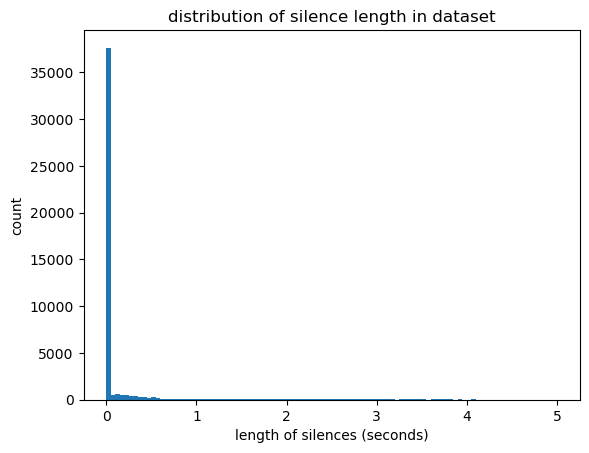

In [40]:
lengths = []
for shot_id in range(0, len(video_metadata)):
    # Get time 
    fps = video_metadata[shot_id]["fps"]
    file_name = video_metadata[shot_id]["name"]
    transcript_on_screen = json.load(open(os.path.join(*[output_folder, "ttext", file_name+"_{}.json".format(0)]), "rb"))["text"]
    transcript_off_screen = json.load(open(os.path.join(*[output_folder, "ttext", file_name+"_{}.json".format(1)]), "rb"))["text"]
    for i in range(1, len(transcript_on_screen)):
        word = transcript_on_screen[i]["text"]
        start = transcript_on_screen[i]["start"]
        end = transcript_on_screen[i]["end"]
        lengths.append(start - transcript_on_screen[i-1]["end"])
    for i in range(1, len(transcript_off_screen)):
        word = transcript_off_screen[i]["text"]
        start = transcript_off_screen[i]["start"]
        end = transcript_off_screen[i]["end"]
        lengths.append(start - transcript_off_screen[i-1]["end"])
plt.title("distribution of silence length in dataset")
plt.xlabel("length of silences (seconds)")
plt.ylabel("count")
plt.hist(lengths, bins=100, range=[0, 5])
plt.show()

##### Use a line search to determine the best length of silence threshold to split sentences

[0.986328125, 0.986328125, 0.986328125, 0.767578125, 0.638671875, 0.564453125, 0.560546875, 0.279296875]


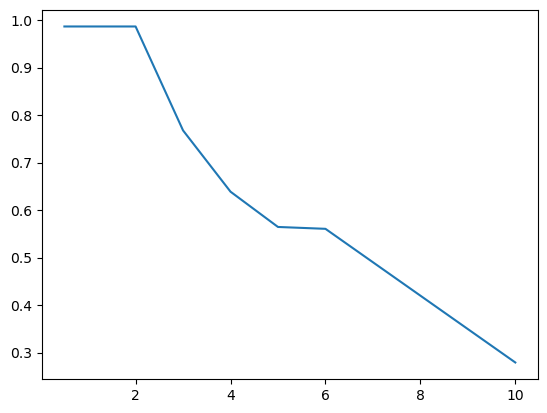

In [53]:
video_names_path = os.path.join(*[output_folder, "metadata.json"])
video_metadata = {}
with open(video_names_path, mode="r") as f:
    video_metadata = json.load(f)["data"]

threshold = 0.4
def find_average_sentence_length(threshold):
    lengths = []
    for shot_id in range(0, len(video_metadata)):
        # Get time 
        fps = video_metadata[shot_id]["fps"]
        file_name = video_metadata[shot_id]["name"]
        transcript_on_screen = json.load(open(os.path.join(*[output_folder, "ttext", file_name+"_{}.json".format(0)]), "rb"))["text"]
        transcript_off_screen = json.load(open(os.path.join(*[output_folder, "ttext", file_name+"_{}.json".format(1)]), "rb"))["text"]
        # parse the transcript for sentences:
        if len(transcript_on_screen) >= 2:
            interval_of_sentences, transcript_of_sentences = parse_for_sentence_intervals(transcript_on_screen, threshold)
            for i in transcript_of_sentences:
                lengths.append(len(i))
        if len(transcript_off_screen) >= 2: 
            interval_of_sentences, transcript_of_sentences = parse_for_sentence_intervals(transcript_off_screen, threshold)
            for i in transcript_of_sentences:
                lengths.append(len(i))     
    return np.mean(lengths)
def dt_line_search(t_min, t_max, weighting, max_iter = 8):
    for i in range(0, max_iter):
        val_max_length = find_average_sentence_length(t_max)
        objective_val_max = -val_max_length + weighting * t_max
        val_min_length = find_average_sentence_length(t_min)
        objective_val_min = -val_min_length + weighting * t_min

        if objective_val_max <= objective_val_min:
            t_min = (t_min + t_max) / 2
        else:
            t_max = (t_min + t_max) / 2  
    return (t_max + t_min) / 2
optimal_t = []
coefficients = [0.5, 1, 2, 3, 4, 5, 6, 10]
for c in coefficients:
    t_val = dt_line_search(0, 1, c)
    optimal_t.append(t_val)
print(optimal_t)
plt.plot(coefficients, optimal_t)

#### Parse sentence dataset

In [85]:
video_names_path = os.path.join(*[output_folder, "metadata.json"])
video_metadata = {}
with open(video_names_path, mode="r") as f:
    video_metadata = json.load(f)["data"]


lengths = []
for shot_id in range(0, len(video_metadata)):
    # Get time 
    fps = video_metadata[shot_id]["fps"]
    file_name = video_metadata[shot_id]["name"]
    # need gaze to figure out what the time array's shape should be 
    gaze = pkl.load(open(os.path.join(*[output_folder, "tgaze", file_name+".pkl"]), "rb"))
    transcript_on_screen = json.load(open(os.path.join(*[output_folder, "ttext", file_name+"_{}.json".format(0)]), "rb"))["text"]
    transcript_off_screen = json.load(open(os.path.join(*[output_folder, "ttext", file_name+"_{}.json".format(1)]), "rb"))["text"]
    # parse the transcript for sentences:
    interval_of_sentences_onscreen, ___ = parse_for_sentence_intervals(transcript_on_screen, 0.56)
    interval_of_sentences_offscreen, ___ = parse_for_sentence_intervals(transcript_off_screen, 0.56)
    ts = np.arange(0, gaze.shape[0]) / fps
    # the output array will have the following features:
    #   time since start of word (0 in silence, which means it will start at zero)
    #   time till end of word (0 in silence as well,)
    #   length of sentence 
    #   time since start of silence (0 when speaking)
    #   time till end of silence (0 when speaking)
    #   length of silence
    off_screen_vec = generate_sentence_structure_values_real(ts, interval_of_sentences_offscreen)
    on_screen_vec = generate_sentence_structure_values_real(ts, interval_of_sentences_onscreen)
    # get storage path
    sentence_location_onscreen = os.path.join(*[output_folder, "tsentence_timing", file_name+"_0.pkl"])
    sentence_location_offscreen = os.path.join(*[output_folder, "tsentence_timing", file_name+"_1.pkl"])
    pkl.dump(on_screen_vec, open(sentence_location_onscreen,  "wb"))
    pkl.dump(off_screen_vec, open(sentence_location_offscreen,  "wb"))
    


In [97]:
dataset = PrePorcessVideoWindowLoader(output_folder)
# dataset metadata
dataset_metadata_path = os.path.join(output_folder, "video_to_window_metadata.json")
try:
    video_to_window = json.load(open(dataset_metadata_path, "r"))
except:
    video_to_window = {}
for idx in range(0, len(dataset)):
    file_name = dataset.clip_metadata[idx]["file_name"]
    fps = dataset.clip_metadata[idx]["fps"]
    v_range = dataset.clip_metadata[idx]["video_range"]
    ts_target = np.arange(0, window_length * target_fps) / target_fps
    sentence_location_onscreen = os.path.join(*[output_folder, "tsentence_timing", file_name+"_0.pkl"])
    sentence_location_offscreen = os.path.join(*[output_folder, "tsentence_timing", file_name+"_1.pkl"])
    # load the vector
    on_screen_sentence_vec = pkl.load(open(sentence_location_onscreen, "rb"))
    off_screen_sentence_vec = pkl.load(open(sentence_location_offscreen, "rb"))
    # generate the 10 second segments:
    on_screen_sentence_vec_window = on_screen_sentence_vec[v_range[0]:v_range[1]]
    off_screen_sentence_vec_window = off_screen_sentence_vec[v_range[0]:v_range[1]]
    # save paths for everything
    on_screen_sentence_vec_save_path = os.path.join(*[output_folder, "sentence_timing", "clip_{}_speaker_0.npy".format(idx)])
    off_screen_sentence_vec_save_path = os.path.join(*[output_folder, "sentence_timing", "clip_{}_speaker_1.npy".format(idx)])
    # resample the data
    on_screen_sentence_vec_window_interp = interp1d(ts_v, on_screen_sentence_vec_window, axis=0, bounds_error=False, fill_value="extrapolate")
    off_screen_sentence_vec_window_interp = interp1d(ts_v, off_screen_sentence_vec_window, axis=0, bounds_error=False, fill_value="extrapolate")
    on_screen_sentence_vec_window_out = on_screen_sentence_vec_window_interp(ts_target)
    off_screen_sentence_vec_window_out = off_screen_sentence_vec_window_interp(ts_target)

    # save_path 
    np.save(on_screen_sentence_vec_save_path, on_screen_sentence_vec_window_out)
    np.save(off_screen_sentence_vec_save_path, off_screen_sentence_vec_window_out)


ValueError: x and y arrays must be equal in length along interpolation axis.

In [ ]:
for idx in range(0, len(dataset)):
    file_name = dataset.clip_metadata[idx]["file_name"]
    fps = dataset.clip_metadata[idx]["fps"]
    v_range = dataset.clip_metadata[idx]["video_range"]
    sentence_location_onscreen = os.path.join(*[output_folder, "sentence_timing", file_name+"_0.pkl"])
    sentence_location_offscreen = os.path.join(*[output_folder, "sentence_timing", file_name+"_1.pkl"])
    # keep track of the video to audio index
    try: 
        video_to_window[file_name].append(i)
    except:
        video_to_window[file_name] = [i]
    # first interpolate the gaze, head and blinks
    ts_v = np.arange(0, gaze.shape[0]) / fps
    ts_target = np.arange(0, window_length * target_fps) / target_fps
    # gaze



    gaze_interp = interp1d(ts_v, gaze, axis=0, bounds_error=False, fill_value="extrapolate")
    gaze_out = gaze_interp(ts_target)